In [1]:
import numpy as np

In [15]:

head_embed=np.load('head_biencodings.npy').item()
body_embed=np.load('body_biencodings.npy').item()

In [2]:

from baseline.utils import dataset, generate_test_splits, score
train_dataset = dataset.DataSet()
test_dataset = dataset.DataSet('test')

Reading dataset
Total stances: 49972
Total bodies: 1683
Reading dataset
Total stances: 25413
Total bodies: 904


In [3]:
len(train_dataset.stances)

49972

In [3]:
labels_train=[]
for s in train_dataset.stances:
    labels_train.append(s['Stance'])
    
labels_test=[]
for s in test_dataset.stances:
    labels_test.append(s['Stance'])


In [7]:
path='/home/kamal/CS249/Codes/'
tfidf_train=np.load(path+'train_tf_idf_full.npy')
handmade_train=np.load(path+'train_hand_baseline.npy')
tfidf_test=np.load(path+'test_tf_idf_full.npy')
handmade_test=np.load(path+'test_hand_baseline.npy')

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
skpfeatures_train=[]
labels_train=[]
for s in train_dataset.stances:
    i=s['Body ID']
    a=head_embed[s['Headline']]
    b=np.average(body_embed[i],axis=0)
    b=np.nan_to_num(b)
    x1=np.multiply(a,b)
    x2=np.absolute(np.subtract(a,b))
    x3=cosine_similarity(a.reshape(1, -1),b.reshape(1, -1))
    skpfeatures_train.append(np.concatenate([x1,x2,x3[0]]))
    labels_train.append(s['Stance'])

skpfeatures_test=[]
labels_test=[]
for s in test_dataset.stances:
    i=s['Body ID']
    a=head_embed[s['Headline']]
    b=np.average(body_embed[i],axis=0)
    b=np.nan_to_num(b)
    x1=np.multiply(a,b)
    x2=np.absolute(np.subtract(a,b))
    x3=cosine_similarity(a.reshape(1, -1),b.reshape(1, -1))
    skpfeatures_test.append(np.concatenate([x1,x2,x3[0]]))
    labels_test.append(s['Stance'])


In [45]:
x3[0].shape

(1,)

In [17]:
handmade_train=np.hstack((handmade_train,np.load(path+'train_features_sentiment.npy')))
handmade_test=np.hstack((handmade_test,np.load(path+'test_features_sentiment.npy')))

In [4]:
from keras.layers import Input, Dense,Dropout,concatenate
from keras.models import Model,Sequential 
from keras import regularizers,optimizers

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [22]:
input1 =Input(shape=(9600,), dtype='float32', name='skipfeatures')
x1=Dense(500, activation='sigmoid',kernel_regularizer=regularizers.l2(0.00000001))(input1)
x1=Dropout(0.2)(x1)
x1=Dense(100, activation='sigmoid')(x1)

input2 =Input(shape=(47,), dtype='float32', name='handfeatures')
x2=Dense(20, activation='relu')(input2)

input3 =Input(shape=(10001,), dtype='float32', name='tfidffeatures')
x3=Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.00005))(input3)
x3=Dropout(0.4)(x3)
x3=Dense(50, activation='relu')(x3)

x = concatenate([x1,x2,x3])
predictions=Dense(4,activation='softmax')(x)

In [23]:
model=Model(inputs=[input1,input2,input3], outputs=predictions)
ad=optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=ad, metrics=['accuracy'])

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encodertrain = LabelEncoder()
    
encodertrain.fit(labels_train)
encoded_Y = encodertrain.transform(labels_train)
Y_train_labels = np_utils.to_categorical(encoded_Y)
  

encodertest = LabelEncoder()
encodertest.fit(labels_test)
encoded_Y = encodertest.transform(labels_test)
Y_test_labels = np_utils.to_categorical(encoded_Y)

49972
25413
19645
19645


49972
25413


In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [36]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
skipfeatures (InputLayer)       (None, 9600)         0                                            
__________________________________________________________________________________________________
tfidffeatures (InputLayer)      (None, 10001)        0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 500)          4800500     skipfeatures[0][0]               
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 500)          5001000     tfidffeatures[0][0]              
__________________________________________________________________________________________________
dropout_5 

In [35]:
model.fit([np.array(skpfeatures_train),handmade_train,tfidf_train],np.array(Y_train_labels),batch_size=100,epochs=10,verbose=1)

MemoryError: 

In [37]:
def evaluate_answer(model, feats1,feats2,feats3, truelabels,lenc):
    predicted = model.predict([np.array(feats1),feats2,feats3])
    predicted = np.argmax(predicted,axis =-1)
    ground = list()
    pred = list()
    t=np.argmax(truelabels,axis =-1)
    for i in predicted:
        pred.append(encodertest.inverse_transform(i))
    for i in t:
        ground.append(encodertest.inverse_transform(i))
    score.report_score(ground, pred)

In [38]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

evaluate_answer(model,skpfeatures_test,handmade_test,tfidf_test, Y_test_labels,encodertest)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    997    |     3     |    796    |    107    |
-------------------------------------------------------------
| disagree  |    269    |    19     |    310    |    99     |
-------------------------------------------------------------
|  discuss  |    733    |    15     |   3515    |    201    |
-------------------------------------------------------------
| unrelated |    139    |     8     |    480    |   17722   |
-------------------------------------------------------------
Score: 9493.0 out of 11651.25	(81.47623645531596%)


In [29]:
encodertest.classes_

array(['agree', 'disagree', 'discuss', 'unrelated'], dtype='<U9')

In [47]:
features_train = np.memmap('Fullfeattrain.myarray', dtype=float, mode='w+',shape=(49972,19649))
ftrain=[]
for i in range(0,49972):
    x1=skpfeatures_train[i]
    x2=handmade_train[i]
    x3=tfidf_train[i]
    ftrain.append(np.concatenate([x1,x2,x3]))
    
features_train[:]=ftrain[:]

features_test = np.memmap('Fullfeattest.myarray', dtype=float, mode='w+',shape=(25413,19649))
ftest=[]
for i in range(0,25413):
    x1=skpfeatures_test[i]
    x2=handmade_test[i]
    x3=tfidf_test[i]
    ftest.append(np.concatenate([x1,x2,x3]))
    
features_test[:]=ftest[:]

del features_test
del features_train

In [6]:
featstrain=np.memmap('Fullfeattrain.myarray', dtype=float, mode='r',shape=(49972,19649))
featstest=np.memmap('Fullfeattest.myarray', dtype=float, mode='r',shape=(25413,19649))

In [12]:
from lightgbm import LGBMClassifier
gbm=LGBMClassifier(objective='multiclass',learning_rate= 0.1,n_estimators= 40,num_leaves=31)
gbm.fit(featstrain,labels_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=40,
        n_jobs=-1, num_leaves=31, objective='multiclass',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [15]:
def evaluate_answer_single(model, feats, truelabels,lenc):
    predicted = model.predict_proba(np.array(feats))
    predicted = np.argmax(predicted,axis =-1)
    ground = list()
    pred = list()
    t=np.argmax(truelabels,axis =-1)
    for i in predicted:
        pred.append(encodertest.inverse_transform(i))
    for i in t:
        ground.append(encodertest.inverse_transform(i))
    score.report_score(ground, pred)

In [17]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

evaluate_answer_single(gbm,featstest, Y_test_labels,encodertest)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    887    |     2     |    863    |    151    |
-------------------------------------------------------------
| disagree  |    226    |     7     |    326    |    138    |
-------------------------------------------------------------
|  discuss  |    581    |     1     |   3548    |    334    |
-------------------------------------------------------------
| unrelated |    32     |     0     |    187    |   18130   |
-------------------------------------------------------------
Score: 9474.25 out of 11651.25	(81.31530951614634%)


In [22]:
featstrain[0]

memmap([-7.74231594e-05, -7.67138317e-06, -2.91246892e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [7]:
model = Sequential()
model.add(Dense(500, input_dim=19649, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dropout(0.2))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.fit(featstrain,np.array(Y_train_labels),batch_size=128,epochs=10,verbose=1)

Epoch 1/10
49972/49972 [==============================] - 922s 18ms/step - loss: 0.3331 - acc: 0.8794
Epoch 2/10
49972/49972 [==============================] - 56s 1ms/step - loss: 0.2024 - acc: 0.9240
Epoch 3/10
49972/49972 [==============================] - 56s 1ms/step - loss: 0.1524 - acc: 0.9423
Epoch 4/10
49972/49972 [==============================] - 57s 1ms/step - loss: 0.1224 - acc: 0.9531
Epoch 5/10
49972/49972 [==============================] - 56s 1ms/step - loss: 0.0988 - acc: 0.9627
Epoch 6/10
49972/49972 [==============================] - 57s 1ms/step - loss: 0.0834 - acc: 0.9680
Epoch 7/10
 2432/49972 [>.............................] - ETA: 52s - loss: 0.0809 - acc: 0.9720

KeyboardInterrupt: 

In [9]:
def evaluate_answer_single_dense(model, feats, truelabels,lenc):
    predicted = model.predict(np.array(feats))
    predicted = np.argmax(predicted,axis =-1)
    ground = list()
    pred = list()
    t=np.argmax(truelabels,axis =-1)
    for i in predicted:
        pred.append(encodertest.inverse_transform(i))
    for i in t:
        ground.append(encodertest.inverse_transform(i))
    score.report_score(ground, pred)

In [10]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

evaluate_answer_single_dense(model,featstest, Y_test_labels,encodertest)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    990    |     3     |    773    |    137    |
-------------------------------------------------------------
| disagree  |    252    |    21     |    297    |    127    |
-------------------------------------------------------------
|  discuss  |    518    |     5     |   3669    |    272    |
-------------------------------------------------------------
| unrelated |    66     |     3     |    417    |   17863   |
-------------------------------------------------------------
Score: 9607.75 out of 11651.25	(82.46110932303401%)


In [64]:
predicted=model.predict(np.array(featstest))

In [65]:
correct=list()
incorr=list()
i=0
pred=np.argmax(predicted,axis =-1)
true=np.argmax(Y_test_labels,axis =-1)
for s in test_dataset.stances:
    body=test_dataset.articles[s['Body ID']]
    headline=s['Headline']
    if(pred[i]!=true[i]):
        incorr.append((len(headline.split(' ')),len(body.split(' ')),encodertest.inverse_transform(pred[i]),encodertest.inverse_transform(true[i])))
    else:
        correct.append((len(headline.split(' ')),len(body.split(' ')),encodertest.inverse_transform(pred[i]),encodertest.inverse_transform(true[i])))
    i+=1
    

In [37]:
sum(int(incorr[:][1]))

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [45]:
y=[x[1] for x in incorr]

In [47]:
np.mean(y)

367.3240418118467

In [49]:
y1=[x[1] for x in correct]
np.mean(y1)

333.6788360023067

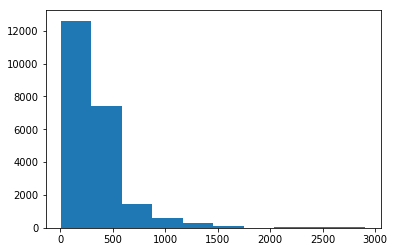

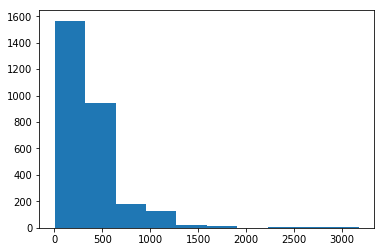

In [60]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y1) 
plt.show()
plt.figure()
plt.hist(y) 
plt.show()

In [57]:
[k for k in y <100]

TypeError: '<' not supported between instances of 'list' and 'int'

In [71]:
data=np.load('datavar.npy').item()
correct=list()
incorr=list()
i=0
pred=np.argmax(predicted,axis =-1)
true=np.argmax(Y_test_labels,axis =-1)
for s in test_dataset.stances:
    body=test_dataset.articles[s['Body ID']]
    headline=s['Headline']
    if(pred[i]!=true[i]):
        incorr.append((s['Headline'],data[s['Body ID']],encodertest.inverse_transform(pred[i]),encodertest.inverse_transform(true[i])))
    else:
        correct.append((s['Headline'],data[s['Body ID']],encodertest.inverse_transform(pred[i]),encodertest.inverse_transform(true[i])))
    i+=1

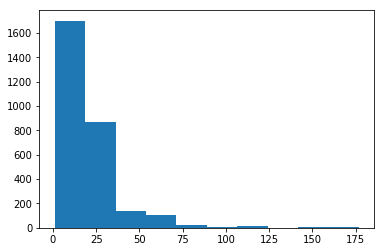

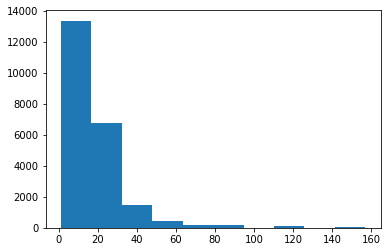

In [69]:
y=[x[1] for x in correct]
y1=[x[1] for x in incorr]
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y1) 
plt.show()
plt.figure()
plt.hist(y) 
plt.show()

In [74]:
cnt=0
for (x,y,z,w) in incorr:
    if w=='disagree':
        print(x)
        print(y)
        print(z+'-------------------\n')
        cnt+=1

Disgusting! Joan Rivers Doc Gwen Korovin’s Sick Selfie EXPOSED — Last Photo Of Comic Icon, When She Was Under Anesthesia, At Center Of Medical Investigation
["If the bizarre story about Joan Rivers' doctor pausing to take a selfie in the operating room minutes before the 81-year-old comedienne went into cardiac arrest on August 29 sounded outlandish, that's because it was.", "So says Dr Gwen Korovin, Rivers' personal physician who on Thursday night shot down a CNN report claiming Korovin was so star-struck she took the opportunity of her celebrity patient being unconscious to snap a souvenir photo of the two of them together.", "CNN, citing sources close to the investigation being carried out by the medical examiner's office, is standing by its claim that a sedated Rivers was clearly visible in Korovin's procedure room selfie - an allegation Korovin's lawyers are calling lies.", 'Korovin, (known as the patron saint of Broadway singers and actors for her work tending to the likes of Lad

In [73]:
cnt

676

In [75]:
train_pred=model.predict(featstrain)
test_pred=model.predict(featstest)

In [77]:
len(train_pred[0])

4

In [78]:
np.savetxt('train_pred.csv', train_pred, delimiter=',',newline='\n')
np.savetxt('test_pred.csv', test_pred, delimiter=',',newline='\n')

In [80]:
encodertest.inverse_transform([0,1,2,3])

array(['agree', 'disagree', 'discuss', 'unrelated'], dtype='<U9')

In [84]:
encodertest.inverse_transform(np.argmax(test_pred[22],axis=-1))

'agree'